The US Geologic Survey, the federal agency that maintains stream gages, is entering the 21st century by making it easier to find and retrieve their data. Most development so far has been in R, but a few blessed individuals have been developing a similar package in Python, [dataretrieval](https://github.com/USGS-python/dataretrieval). The USGS is putting together resources and packages for [automated data retrieval](https://waterservices.usgs.gov/rest/Site-Service.html).


In [1]:
# Import libraries
import matplotlib.pyplot as plt
from dataretrieval import nwis
import pandas as pd
import numpy as np

In [2]:
# pip install lxml

# Part 1: EARS33 example activity

In [3]:
# Make a list of strings corresponding to site IDs. 
# These use quotes to denote they are strings and not numbers
# They are separated by commas and bound by square brackets

sitelist = ["01075000", "01081500", "01092000"]

In [4]:
site_info = nwis.get_record(sites=sitelist, service='site')

print('Available data are:\n', site_info.columns.values) # "\n" just puts a line break in a text (string)
print('Station names are:\n', site_info['station_nm'])


Available data are:
 ['agency_cd' 'site_no' 'station_nm' 'site_tp_cd' 'lat_va' 'long_va'
 'dec_lat_va' 'dec_long_va' 'coord_meth_cd' 'coord_acy_cd'
 'coord_datum_cd' 'dec_coord_datum_cd' 'district_cd' 'state_cd'
 'county_cd' 'country_cd' 'land_net_ds' 'map_nm' 'map_scale_fc' 'alt_va'
 'alt_meth_cd' 'alt_acy_va' 'alt_datum_cd' 'huc_cd' 'basin_cd' 'topo_cd'
 'instruments_cd' 'construction_dt' 'inventory_dt' 'drain_area_va'
 'contrib_drain_area_va' 'tz_cd' 'local_time_fg' 'reliability_cd'
 'gw_file_cd' 'nat_aqfr_cd' 'aqfr_cd' 'aqfr_type_cd' 'well_depth_va'
 'hole_depth_va' 'depth_src_cd' 'project_no']
Station names are:
 0                 PEMIGEWASSET RIVER AT WOODSTOCK, NH
1            MERRIMACK RIVER AT FRANKLIN JUNCTION, NH
2    MERRIMACK R NR GOFFS FALLS, BELOW MANCHESTER, NH
Name: station_nm, dtype: object


Now to Pandas

In [5]:
# Initialize a blank dataframe object
df = pd.DataFrame()

Parameter codes for the USGS are here:https://help.waterdata.usgs.gov/codes-and-parameters/parameters To get discharge, use "00060"

In [6]:
# This loop will iterate through each of the objects in sitelist and assign it 
# a number "i" as it assigns the variable siteNumber to the sitelist object

for i, siteNumber in enumerate(sitelist):
    # This is the parameter code for discharge in cfs
    parameterCode = "00060"
    # These are strings of dates
    startDate = "2022-01-01"
    endDate = "2022-12-31"
    # Make a temporary dataframe to store the records of each site
    df_temp = nwis.get_record(sites=siteNumber, service='dv', start=startDate, end=endDate, parameterCd='00060')
    # And then append each site's data to the previous sites' data
    df = df.append(df_temp)
    # This method keeps our dataframe compact - each of the sites have the same
    # data, and we can always parse by site number later

/scratch/ipykernel_42409/3585421446.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_temp)
/scratch/ipykernel_42409/3585421446.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_temp)
/scratch/ipykernel_42409/3585421446.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_temp)


In [7]:
df

,00060_Mean,00060_Mean_cd,site_no
datetime,,,
2022-01-01 00:00:00+00:00,277.0,A,01075000
2022-01-02 00:00:00+00:00,377.0,A,01075000
2022-01-03 00:00:00+00:00,311.0,"A, e",01075000
2022-01-04 00:00:00+00:00,188.0,"A, e",01075000
2022-01-05 00:00:00+00:00,258.0,A,01075000
...,...,...,...
2022-12-27 00:00:00+00:00,22700.0,P,01092000
2022-12-28 00:00:00+00:00,16300.0,P,01092000
2022-12-29 00:00:00+00:00,12200.0,P,01092000


Provisional data might be bad numbers for discharge:

In [8]:
df.groupby(by='site_no')['00060_Mean'].min()

site_no
01075000   -999999.0
01081500       537.0
01092000       721.0
Name: 00060_Mean, dtype: float64

-999999.0 isn't real, so let's replace with NaN (not zero!)

In [9]:
df.replace(-999999.0, np.nan, inplace=True)

In [10]:
df.groupby(by='site_no')['00060_Mean'].min()

site_no
01075000     65.1
01081500    537.0
01092000    721.0
Name: 00060_Mean, dtype: float64

Now we're going to do a groupby that will [group rows with similar values](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) for a certain column for analysis. After we groupby, we can query the values of a different column, but grouped by the first column.

In this case the code is going to make three separate plots, one for each site_no, of the column 00060_Mean, or mean daily discharge.





Text(0, 0.5, 'Streamflow (cfs)')

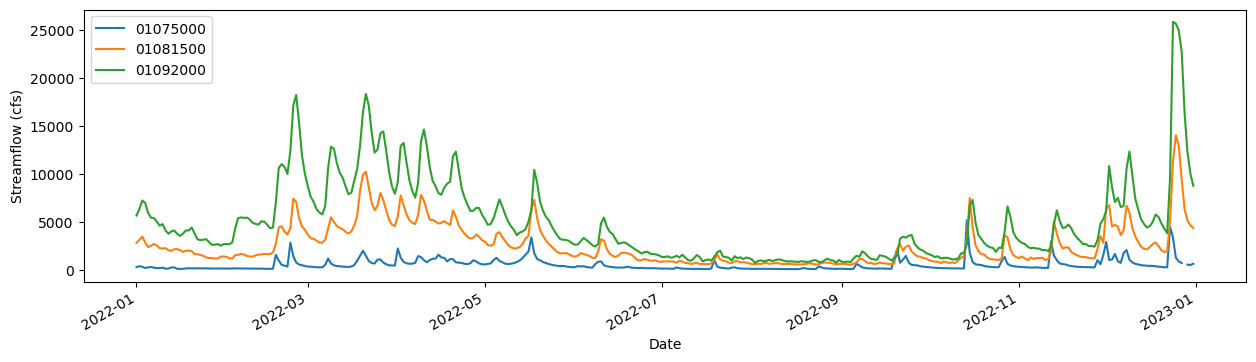

In [11]:
fig, ax = plt.subplots(figsize=(15,4))

for site, group in df.groupby(by='site_no'):
    
    # site_info = nwis.get_record(sites=site, service='site')
    # To do - get name and drainage area as label instead of station label!

    group.plot(y='00060_Mean', ax=ax, legend=True, label=site)

ax.set_xlabel('Date')
ax.set_ylabel('Streamflow (cfs)')

#https://stackoverflow.com/questions/39902522/pandas-groupby-object-in-legend-on-plot

Very cool!

1. Which plot is the lowest drainage area? The highest? How do you know?
2. How might you write an algorithm to determine the timing between peak discharges between upstream and downstream sites?
3. Are the upstream sites always a consistent percentage of the downstream sites' discharges? Why or why not? How might that be explained? What other data might you need to test this idea? BONUS: How might you write an algorithm to track how the relative streamflows change with time? 

# Part 2: discharge trends in Alaskan rivers

So I used this search page to create a table of all Alaska gage sites and then use Pandas to parse the resulting table: https://waterdata.usgs.gov/ak/nwis/current?submitted_form=introduction

In [12]:
import requests

In [13]:
url = 'https://waterdata.usgs.gov/ak/nwis/current?index_pmcode_STATION_NM=1&index_pmcode_DATETIME=2&group_key=basin_cd&format=sitefile_output&sitefile_output_format=html_table&column_name=agency_cd&column_name=site_no&column_name=station_nm&sort_key_2=site_no&html_table_group_key=NONE&rdb_compression=file&list_of_search_criteria=realtime_parameter_selection'

In [14]:
usgs_url = requests.get(url)

In [15]:
# This returns a LIST of dataframes
usgs_data = pd.read_html(usgs_url.text)

In [16]:
# So let's look at the first (and only) dataframe that comes out
usgs_data = usgs_data[0]

usgs_data.head()

,Agency,Site Number,Site Name
0,USGS,15008000,SALMON R NR HYDER AK
1,USGS,15015595,UNUK R BL BLUE R NR WRANGELL AK
2,USGS,15019990,TYEE LK OUTLET NR WRANGELL AK
3,USGS,15024800,STIKINE R NR WRANGELL AK
4,USGS,15041200,TAKU R NR JUNEAU AK


In [17]:
# get_record takes a string
site_string = str(usgs_data.iloc[0]["Site Number"])
# And iloc[0] is "the data at index location 0"
site_info = nwis.get_record(sites=site_string, service='site')
print("Lat: ", site_info['dec_lat_va'])
print("Long: ", site_info['dec_long_va'])


Lat:  0    56.025815
Name: dec_lat_va, dtype: float64
Long:  0   -130.066982
Name: dec_long_va, dtype: float64


In [18]:
df_hist = nwis.get_record(sites=site_string, service='dv', start='1900-01-01', end=endDate, parameterCd='00060')
df_hist.replace(-999999.0, np.nan, inplace=True)

Text(0, 0.5, 'Streamflow (cfs)')

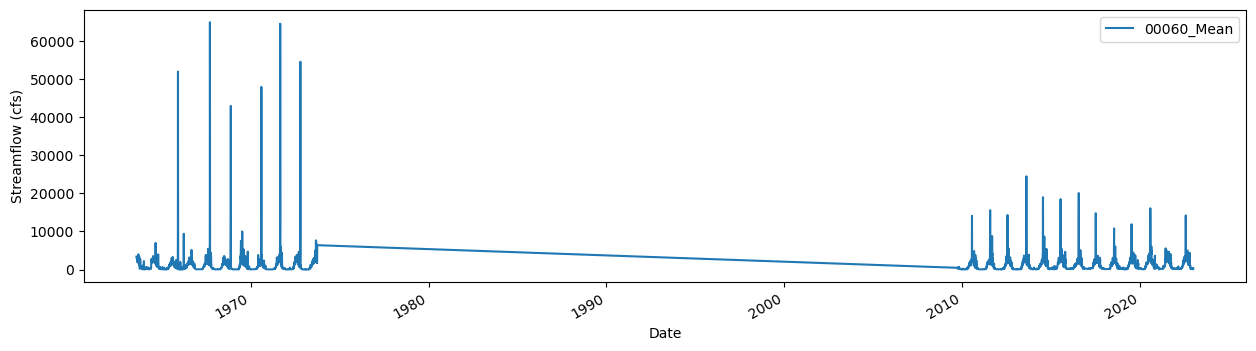

In [19]:
fig, ax = plt.subplots(figsize=(15,4))
data = df_hist.plot(y='00060_Mean', ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Streamflow (cfs)')

In [20]:
#pandas datetimeindex docs: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DatetimeIndex.html
df_hist['year'] = pd.DatetimeIndex(pd.to_datetime(df_hist.index)).year

# This is a slightly weird thing, where the datetime is stored as an "index"
# of the dataframe rather than a column, so I first turned the index into 
# a datetime object with the pd.to_datetime(df_hist.index) call, 
# and then parsed that datetime object for the year

df_hist.head() 

,00060_Mean,00060_Mean_cd,site_no,year
datetime,,,,
1963-08-01 00:00:00+00:00,3400.0,A,15008000,1963
1963-08-02 00:00:00+00:00,3400.0,A,15008000,1963
1963-08-03 00:00:00+00:00,3300.0,A,15008000,1963
1963-08-04 00:00:00+00:00,3200.0,A,15008000,1963
1963-08-05 00:00:00+00:00,3200.0,A,15008000,1963


In [21]:
# Here I'm going to ask "What is the maximum value for each year?" the groupby()
# function puts all the things that have the same value in a specified column
# and then finds the max value, in this case 
# Read more here: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html

annual_max_floods = df_hist.groupby('year').max().reset_index()

# The groupby() function creates this new mini-dataframe, "annual_max_floods",
# which can be manipulated just like our original dataframe, df_hist


# the reset_index() call is just a little nuance where I don't want it to turn
# my year groups into the index of the dataframe, or else Pandas will thing
# I want to plot variables as a timeline, which I don't want to do 

annual_max_floods

,year,00060_Mean,00060_Mean_cd,site_no
0,1963,4000.0,A,15008000
1,1964,7000.0,A,15008000
2,1965,52000.0,A,15008000
3,1966,9400.0,A,15008000
4,1967,65000.0,A,15008000
5,1968,43000.0,A,15008000
6,1969,10000.0,A,15008000
7,1970,48000.0,A,15008000
8,1971,64600.0,A,15008000
9,1972,54600.0,A,15008000


In [22]:
# Here I'm asking Pandas to rank the discharge column in descending order...

# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rank.html
annual_max_floods['rank'] = annual_max_floods['00060_Mean'].rank(ascending=False)

# ...and then show them to me sorted!

# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html
annual_max_floods.sort_values(by=['rank'])

,year,00060_Mean,00060_Mean_cd,site_no,rank
4,1967,65000.0,A,15008000,1.0
8,1971,64600.0,A,15008000,2.0
9,1972,54600.0,A,15008000,3.0
2,1965,52000.0,A,15008000,4.0
7,1970,48000.0,A,15008000,5.0
5,1968,43000.0,A,15008000,6.0
15,2013,24500.0,"A, e",15008000,7.0
18,2016,20100.0,"A, e",15008000,8.0
16,2014,19000.0,"A, e",15008000,9.0
17,2015,18500.0,"A, e",15008000,10.0


<Axes: xlabel='rank', ylabel='00060_Mean'>

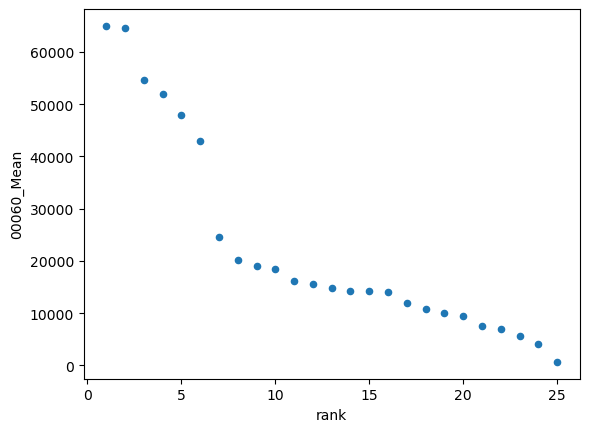

In [23]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.scatter.html
annual_max_floods.plot.scatter(x='rank',y='00060_Mean')

# Why don't you edit the above code to:
# Properly label x and y axes
# maybe...add the year as a color for the data points?

Maybe this is the time to write a function that does all that work for you "under the hood" rather than in big code blocks because you'll want to do the same thing to the data over and over again

In [24]:
def get_annual_floods(site_string):
  # site_string is the string of the gage
  site_info = nwis.get_record(sites=site_string, service='site')
  
  df_hist = nwis.get_record(sites=site_string, service='dv', start='1900-01-01', end=endDate, parameterCd='00060')
  df_hist.replace(-999999.0, np.nan, inplace=True)

  df_hist['year'] = pd.DatetimeIndex(pd.to_datetime(df_hist.index)).year

  annual_max_floods = df_hist.groupby('year').max().reset_index()

  annual_max_floods['rank'] = annual_max_floods['00060_Mean'].rank(ascending=False)

  # And then this is the output to your function: a sorted dataframe
  return annual_max_floods.sort_values(by=['rank'])


<Axes: xlabel='rank', ylabel='00060_Mean'>

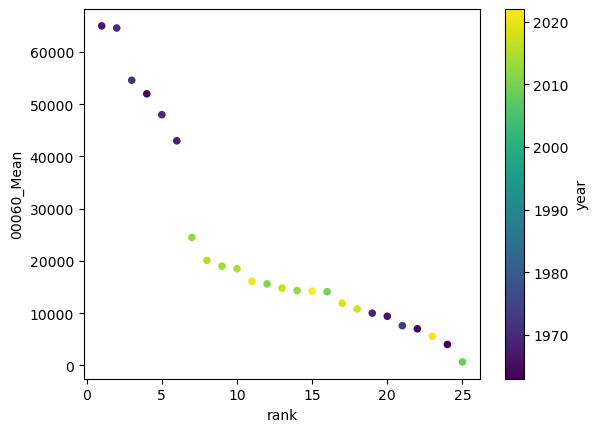

In [25]:
max_flood_data = get_annual_floods(str(usgs_data.iloc[0]["Site Number"]))
max_flood_data.plot.scatter(x='rank',y='00060_Mean', c='year', cmap='viridis')

<Axes: xlabel='rank', ylabel='00060_Mean'>

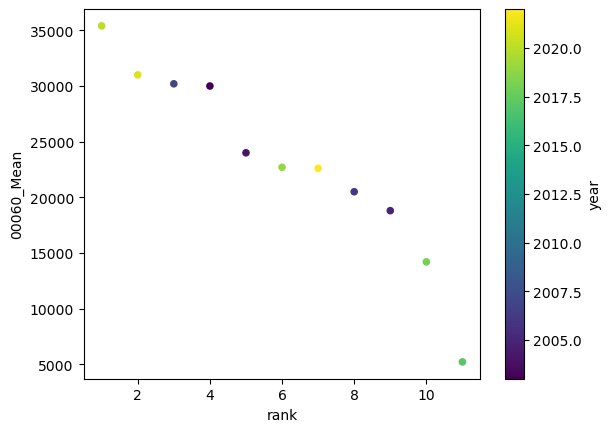

In [26]:
max_flood_data = get_annual_floods(str(usgs_data.iloc[1]["Site Number"]))
max_flood_data.plot.scatter(x='rank',y='00060_Mean', c='year', cmap='viridis')

<Axes: xlabel='rank', ylabel='00060_Mean'>

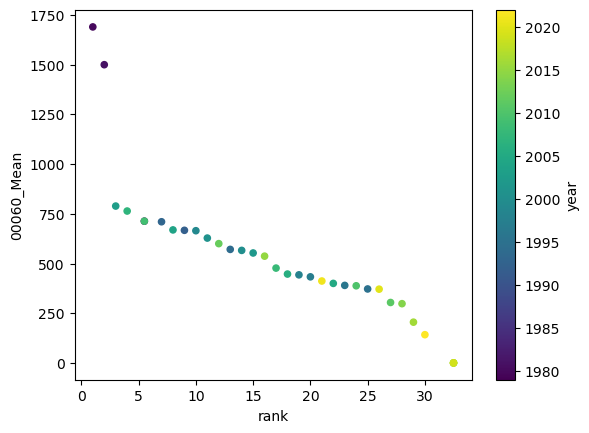

In [27]:
max_flood_data = get_annual_floods(str(usgs_data.iloc[2]["Site Number"]))
max_flood_data.plot.scatter(x='rank',y='00060_Mean', c='year', cmap='viridis')

Fun!!

# Part 3: Hackathon prompt

One of the things I wonder in my work is based on climate change, will the biggest discharge events (which have historically occurred early in the growing season and are associated with snowmelt) instead be associated with rainstorms later in the growing season, when the ground is more thawed?

Hackathon prompt: can you test the hypothesis that ***maximum floods are occurring later in the year?*** And **are those floods getting bigger**?

Ingredients:


1.   Sitewise parsing of maximum flood dates
2.   Some means of quantifying the trend in date of the peak flood (perhaps a [regression line fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html) to the day of year of max flood?
3.   Some means of reducing that quantification of trend down to a single number or variable that can be added to the `usgs_data` dataframe 

